**BASIC MNIST EXAMPLE WITH MLP**

Imports...

In [1]:
from numpy.random import seed
seed(86148)

from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import BatchNormalization as BN
from tensorflow.keras.layers import GaussianNoise as GN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Input, Reshape
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler as LRS
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


Init Plugin
Init Graph Optimizer
Init Kernel


Define batch size, number of epochs and number of classes

In [2]:
batch_size = 128
epochs = 100
num_classes=10
dropout = 0.3

Load MNIST and transform



In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('training set', x_train.shape)
print('test set', x_test.shape)

x_train = x_train.reshape(60000, 28,28,1)
x_test = x_test.reshape(10000, 28,28,1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize [0..255]-->[0..1]
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

training set (60000, 28, 28)
test set (10000, 28, 28)


Define the NN topology, a sequential model with 2 hidden layers

In [4]:
model = Sequential()
model.add(Reshape(target_shape=(784,), input_shape=(28,28,1)))
model.add(GN(0.2))

model.add(Dense(1024))
model.add(BN())
model.add(GN(0.2))
#model.add(Dropout(dropout))
model.add(Activation('relu'))


model.add(Dense(1024))
model.add(BN())
model.add(GN(0.2))
#model.add(Dropout(dropout))
model.add(Activation('relu'))


model.add(Dense(num_classes, activation='softmax'))

model.summary()


Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 784)               0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              803840    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 1024)              0         
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)           

2021-12-26 18:00:59.599812: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-26 18:00:59.599923: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Define an optimizer 

In [5]:
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9) # "adam" 

Compile the model, define loss and link the optimizer

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

Finally, train the model and evaluate over the test data

In [7]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    zoom_range=0.2,
    rotation_range = 5
)


def scheduler(epoch):
    if epoch < 25:
        return .1
    elif epoch < 50:
        return 0.01
    else:
        return 0.001


filepath_val_acc="./backup/model.best.hdf5"
checkpoint_val_acc = ModelCheckpoint(filepath_val_acc, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint_val_acc]    
    
history = model.fit(
    datagen.flow(x_train, y_train,batch_size=batch_size),             
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test),
    callbacks=[LRS(scheduler), checkpoint_val_acc]
)

# Evaluate over test
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(f"Test error: {((1-score[1]) * 100):.3f}%")

2021-12-26 18:00:59.864760: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-26 18:00:59.864872: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-26 18:01:00.025207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100
469/469 [==============================] - ETA: 0s - loss: 0.6276 - accuracy: 0.8227

2021-12-26 18:01:07.868803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 9s 19ms/step - loss: 0.6276 - accuracy: 0.8227 - val_loss: 0.1200 - val_accuracy: 0.9626

Epoch 00001: val_accuracy improved from -inf to 0.96260, saving model to ./backup/model.best.hdf5
Epoch 2/100
469/469 [==============================] - 9s 19ms/step - loss: 0.2810 - accuracy: 0.9160 - val_loss: 0.0764 - val_accuracy: 0.9762

Epoch 00002: val_accuracy improved from 0.96260 to 0.97620, saving model to ./backup/model.best.hdf5
Epoch 3/100
469/469 [==============================] - 9s 19ms/step - loss: 0.2144 - accuracy: 0.9336 - val_loss: 0.0829 - val_accuracy: 0.9735

Epoch 00003: val_accuracy did not improve from 0.97620
Epoch 4/100
469/469 [==============================] - 9s 19ms/step - loss: 0.1869 - accuracy: 0.9421 - val_loss: 0.0573 - val_accuracy: 0.9816

Epoch 00004: val_accuracy improved from 0.97620 to 0.98160, saving model to ./backup/model.best.hdf5
Epoch 5/100
469/469 [==============================] - 9s 19ms/step - loss: 0

469/469 [==============================] - 9s 19ms/step - loss: 0.0616 - accuracy: 0.9804 - val_loss: 0.0205 - val_accuracy: 0.9930

Epoch 00039: val_accuracy did not improve from 0.99320
Epoch 40/100
469/469 [==============================] - 9s 19ms/step - loss: 0.0615 - accuracy: 0.9804 - val_loss: 0.0200 - val_accuracy: 0.9928

Epoch 00040: val_accuracy did not improve from 0.99320
Epoch 41/100
469/469 [==============================] - 9s 19ms/step - loss: 0.0604 - accuracy: 0.9800 - val_loss: 0.0201 - val_accuracy: 0.9928

Epoch 00041: val_accuracy did not improve from 0.99320
Epoch 42/100
469/469 [==============================] - 9s 19ms/step - loss: 0.0604 - accuracy: 0.9800 - val_loss: 0.0201 - val_accuracy: 0.9933

Epoch 00042: val_accuracy improved from 0.99320 to 0.99330, saving model to ./backup/model.best.hdf5
Epoch 43/100
469/469 [==============================] - 9s 19ms/step - loss: 0.0583 - accuracy: 0.9814 - val_loss: 0.0197 - val_accuracy: 0.9936

Epoch 00043: val_

469/469 [==============================] - 9s 19ms/step - loss: 0.0557 - accuracy: 0.9819 - val_loss: 0.0188 - val_accuracy: 0.9933

Epoch 00079: val_accuracy did not improve from 0.99360
Epoch 80/100
469/469 [==============================] - 9s 19ms/step - loss: 0.0572 - accuracy: 0.9819 - val_loss: 0.0190 - val_accuracy: 0.9927

Epoch 00080: val_accuracy did not improve from 0.99360
Epoch 81/100
469/469 [==============================] - 9s 19ms/step - loss: 0.0563 - accuracy: 0.9824 - val_loss: 0.0188 - val_accuracy: 0.9932

Epoch 00081: val_accuracy did not improve from 0.99360
Epoch 82/100
469/469 [==============================] - 9s 19ms/step - loss: 0.0563 - accuracy: 0.9816 - val_loss: 0.0188 - val_accuracy: 0.9930

Epoch 00082: val_accuracy did not improve from 0.99360
Epoch 83/100
469/469 [==============================] - 9s 19ms/step - loss: 0.0543 - accuracy: 0.9826 - val_loss: 0.0188 - val_accuracy: 0.9931

Epoch 00083: val_accuracy did not improve from 0.99360
Epoch 84

In [8]:
import matplotlib.pyplot as plt

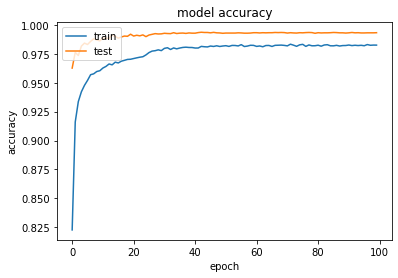

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()